$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\count}[2]{\underset{#1}{\overset{#2}{\operatorname{\#}}}}
$

# Sample-by-Sample Linear Regression

Also referred to as sequential, on-line, or stochastic gradient descent, training.

Remember how we started deriving the expression for the weights that
minimized the sum of squared errors of a linear model?

With $g$ being an affine (linear + constant) function of $x$,

$$
    g(\xv;\wv) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_D x_D = \xv^T \wv
$$

having parameters $\wv = (w_0, w_1, w_2, \ldots, w_D)$, we derived the
solution to 

$$
\begin{align*}
\wv_{\mbox{best}} &= \argmin{\wv} \sum_{n=1}^N (t_n - g(\xv_n ; \wv))^2\\
 & = \argmin{\wv} \sum_{n=1}^N (t_n - \xv_n^T \wv)^2
 \end{align*}
$$

We did this by rewriting the above summation as a matrix expression,
taking its derivative with respect to $\wv$, setting the derivative
equal to zero, and solving for $\wv$.

$$
      \wv = (X^T X)^{-1} X^T T
$$

But what if you have thousands or millions of samples?  $X$ and $T$
can be quite large. To avoid dealing with matrix operations on huge
matrices, we can derive a sequential algorithm for finding $\wv$ by
using the fact that a derivative of a sum is the sum of the
derivatives.

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (t_n - \xv_n^T \wv)^2}{\partial \wv} 
&= 
\sum_{n=1}^N \frac{\partial (t_n - \xv_n^T \wv)^2}{\partial \wv}\\
&= 
\sum_{n=1}^N 2 (t_n - \xv_n^T  \wv) (-1) \xv_n\\
&= -2 \sum_{n=1}^N (t_n - \xv_n^T  \wv) \xv_n\\
\end{align*}
$$

So far this is just another way to write the matrix equation for
$\wv$.  However, instead of summing over all $N$ samples, what if we
just update $\wv$ after each sample based on the derivative of the
squared error for that sample?  The derivative for a sample $n$ can be
considered as a limited, or noisy, sample of the overall derivative.
Thus, we can take a small step in the direction of the negative derivative to try
to bring a current guess at the weight vector, $\wv^{(k)}$, on
iteration $k$ closer to a value that reduces the overall error. In general this kind of update is called "stochastic approximation".

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \eta (t_n - \xv_n^T  \wv) \xv_n\\
 &= \wv^{(k)} + \eta (t_n - \xv_n^T  \wv) \xv_n
\end{align*}
$$

For this sequential algorithm to converge, $\eta$ must decrease with
each iteration, not too fast but not too slow. 

This algorithm is called the least mean squares (LMS) algorithm
developed by Widrow and Hoff.  It is now often referred to as the
''stochastic gradient descent'' algorithm for linear models.

If we have two output variables, like mpg and horsepower, then $t_n$ is no longer a scalar.  How do we deal with that?  Well, you can loop through each of the target variables and update the corresponding column of weights in $\wv$, or...TA DA!....take advantage of ```numpy``` broadcasting again.  

Say that for the $n^{th}$ input pattern, $\xv_n$, we have two target values, $\tv_n$.  To update the weights $\wv$ we must multiply each error by each input component. This does sound like a double loop.  Well, in the last equation above we already used ```numpy``` broadcasting once in

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \eta (t_n - \xv_n^T  \wv) \xv_n\\
 &= \wv^{(k)} + \eta (t_n - \xv_n^T  \wv) \xv_n
\end{align*}
$$

to remove the loop over all of the components in $\wv_n$.  Now we will use broadcasting again to remove a loop over target components, in $\tv_n$.  We must take care to make sure the matrices are of the right shape in the matrix operations, and that the resulting matrix is the correct shape for $\wv$.  Here we follow the convention that vectors are column vectors.

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \eta \xv_n (\tv_n^T - \xv_n^T  \wv)\\
 &= \wv^{(k)} + \eta \xv_n (\tv_n^T - \xv_n^T  \wv) 
\end{align*}
$$

Let's see, $\eta$ is a scalar, $\xv_n$ is $D+1\times 1$, a column vector with $D+1$ components (counting the constant 1), $\tv_n$ is $K\times 1$
so $\tv_n^T$ is $1\times K$  and $\xv_n^T \wv$ is also $1\times K$.  Stringing these dimensions together in the  calculation gives us $(D+1\times 1) (1\times K)$ results in $D+1\times K$ exactly the correct shape for our weight matrix $\wv$.

Let's animate the progress down the derivative.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output

In [6]:
nSamples = 100
X = np.random.uniform(0,10,(nSamples,1))
T = 2 - 0.1 * X + np.random.normal(0,0.1,(nSamples,1)) + 0.0*(X-6)**2 # Change 0 to 0.05 to try to fit nonlinear cloud

X1 = np.insert(X, 0, 1, axis=1)

X1.shape, T.shape

((100, 2), (100, 1))

In [7]:
np.zeros((2,1))

array([[0.],
       [0.]])

In [8]:
def run(eta, nIterations, stepsPerFrame=10):

    w = np.zeros((2,1))

    # Collect the weights after each update in a list
    ws = [w.copy()]

    xs = np.linspace(0, 10, 100).reshape((-1,1))
    xs1 = np.insert(xs, 0, 1, axis=1)

    fig = plt.figure(figsize=(8, 8))

    step = 0
    for iter in range(nIterations):
        for n in range(nSamples):
        
            step += 1
        
            predicted = X1[n:n+1,:] @ w  # n:n+1 is used instead of n to preserve the 2-dimensional matrix structure
            # Update w using derivative of error for nth sample
            w += eta * X1[n:n+1, :].T * (T[n:n+1, :] - predicted)
            ws.append(w.copy())
        
            if step % stepsPerFrame == 0:
                fig.clf()

                # Plot the X and T data.
                plt.subplot(2, 1, 1)
                plt.plot(X, T, 'o', alpha=0.6, label='Data')
                plt.plot(X[n,0], T[n], 'ko', ms=10, label='Last Trained Sample')

                # Plot the output of our linear model for a range of x values
                plt.plot(xs, xs1 @ w, 'r-', linewidth=5, label='Model')
                plt.xlabel('$x$')
                plt.legend(loc='upper right')
                plt.xlim(0, 10)
                plt.ylim(0, 5)


                # In second panel plot the weights versus the interation number
                plt.subplot(2, 1, 2)
                plt.plot(np.array(ws)[:, :, 0])
                plt.xlabel('Updates')
                plt.xlim(0, nIterations*nSamples)
                plt.ylim(-1, 3)
                plt.legend(('$w_0$', '$w_1$'))
        
                clear_output(wait=True)
                display(fig)
    
    clear_output(wait=True)
    
    return w

array([[0.43186072],
       [0.13392799]])

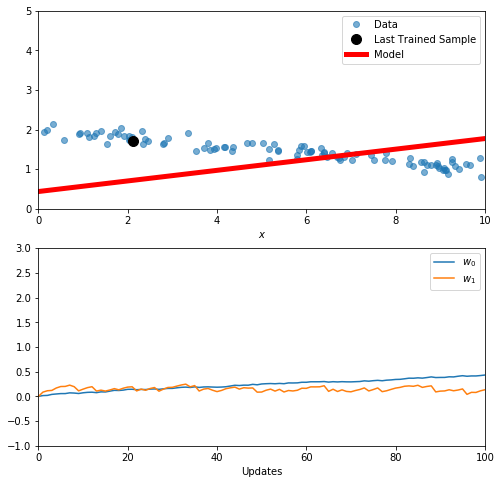

In [9]:
run(0.01, nIterations=1, stepsPerFrame=1)

array([[ 1.98328947],
       [-0.10671079]])

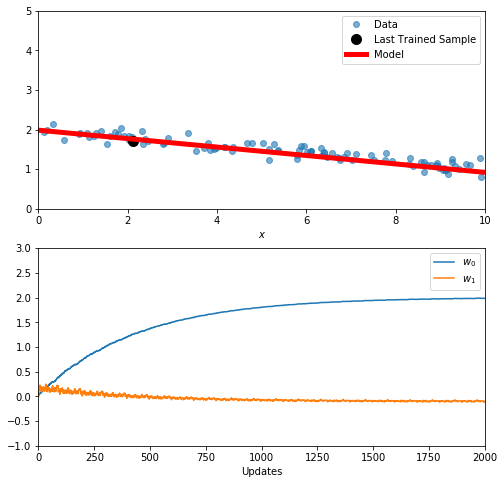

In [10]:
run(0.01, nIterations=20, stepsPerFrame=10)